# Detector de Reggaetones

Como dice el título, vamos a hacer un detector de reggaetones. Para eso armamos un dataset usando
la API de Spotify, que nos da información detallada de cada canción (documentación). Para cada
canción se tienen los siguientes parámetros: 
* acousticness: describes the acousticness of a song (1 => high confidence the track is acoustic). It ranges from 0 to 1.
* danceability: describes the danceability of a song (1 => high confidence the track is danceable). It ranges from 0 to 1.
* duration_ms: the duration of the track in milliseconds.
* energy: it's a perceptual measure of intensity and activity (e.g. death metal has high energy while classical music has low energy). It ranges from 0 to 1.
* instrumentalness: predicts whether a track contains no vocals (1 => high confidence the track has no vocals). It ranges from 0 to 1.
* key: describes the pitch class notation of the song. It ranges from 0 to 11.
* liveness: detects the presence of an audience in the recording (1 => high confidence the track is live). It ranges from 0 to 1.
* loudness: detects the overall loudness of a track in decibels. It ranges from -60dB to 0dB.
* mode: the modality of a track (0 => minor, 1 => major).
* speechiness: detects the presence of spoken words in a track (1 => speech, 0 => non speech, just music). It ranges from 0 to 1.
* tempo: the overall estimated tempo of a track in beats per minute (BPM).
* time_signature: An estimated overall time signature of a track (how many beats are in each bar or measure).

Documentación: https://beta.developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

1. Analiza los dataset data_todotipo.csv y  data_reggaeton.csv . ¿Qué puedes decir de los datos, distribuciones, missing, etc? ¿En qué se diferencian? Entregable: texto/imágenes. **Listo**

2. Consolida los dos datasets en uno solo y genera una marca para las canciones que sean reggaeton en base a los datasets. Entregable: csv con dataset y código (si es que usaste). **Listo**

* Entregable: 
  ** output/P2-all_datasets.csv

3. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para detectar qué canciones son reggaeton. Entregable: modelo en cualquier formato y código (si es que usaste). **Listo**

* Entregable: 
  ** output/P3-classification_isreggaeton_GBT.sav
  ** output/P3-classification_isreggaeton_RANDOMFOREST.sav
  ** output/P3-classification_isreggaeton_LR.sav

4. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usas para evaluar esa performance? ¿Por qué elegiste ese algoritmo en particular? ¿Cómo podrías mejorar la performance? Entregable: texto/imágenes. **Listo**

5. Aplica tu modelo sobre el dataset “data_test.csv”, agregándole a cada registro dos nuevos campos: marca_reggaeton (un 1 cuando es reggaetón, un 0 cuando no lo es) y probabilidad_reggaeton (probabilidad de que la canción sea reggaeton). ¿Cómo elegiste cuáles marcar? ¿De qué depende que predigas la existencia de mayor o menor cantidad de reggaetones? Entregable: texto/imágenes. **Listo**

* Entregable: 
  ** output/P5-test_dataset_classificated_GBT.csv
  ** output/P5-test_dataset_classificated_RANDOMFOREST.csv
  ** output/P5-test_dataset_classificated_LR.csv

* Tiempo máximo de resolución: 2-3 horas.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import re
import pickle
import time
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


## 01- Exploración de datos

* Para partir se realiza una exploración de datos. En primer lugar, se cargan los 3 datasets entregados en una estructura de dato DataFrame la cual es cargada en memoria.

In [2]:
df_all_types = pd.read_csv('input/data_todotipo.csv', index_col=0)
df_only_reggaeton = pd.read_csv('input/data_reggaeton.csv', index_col=0)
df_test = pd.read_csv('input/data_test.csv', index_col=0)

* Verificando el contenido de los dataset cargados como DataFrames

In [3]:
df_only_reggaeton.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new
1,68,0.826,0.704,9,-7.527,1,0.1170,0.1890,0.000048,0.0617,0.741,94.013,205000,1
2,61,0.641,0.693,8,-7.327,1,0.1630,0.0169,0.000000,0.2190,0.899,214.058,184413,2
3,67,0.771,0.815,1,-5.423,0,0.0719,0.1610,0.000020,0.1890,0.524,94.016,205520,3
4,63,0.743,0.787,1,-5.402,1,0.2620,0.0352,0.000000,0.0732,0.719,192.117,172680,4
5,63,0.876,0.692,10,-6.429,1,0.1040,0.1280,0.000000,0.2490,0.757,95.032,227280,5


* Estadistica descriptiva para el dataset data_todotipo alojado en el DataFrame df_all_types

In [4]:
df_all_types.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,id_new
count,2229.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2222.000000,2230.000000
mean,51.938537,0.566439,0.607263,5.175518,-9.641344,0.596760,0.067720,0.346486,0.215211,0.179627,0.530849,118.338830,233872.923042,3.902790,1185.500000
std,17.640772,0.165887,0.282298,3.519774,6.141384,0.490659,0.063484,0.360734,0.351567,0.154093,0.275088,28.527313,77944.498354,0.390686,643.889872
min,0.000000,0.062700,0.001810,0.000000,-42.117000,0.000000,0.023100,0.000002,0.000000,0.018000,0.027900,33.579000,46667.000000,1.000000,71.000000
25%,42.000000,0.456000,0.406250,2.000000,-11.316000,0.000000,0.035500,0.021275,0.000005,0.089600,0.298000,97.411750,187160.250000,4.000000,628.250000
50%,56.000000,0.579000,0.671000,5.000000,-8.017500,1.000000,0.045700,0.189000,0.001660,0.118500,0.538500,117.947000,225257.000000,4.000000,1185.500000
75%,64.000000,0.690750,0.847000,8.000000,-5.699000,1.000000,0.069900,0.667250,0.328750,0.217750,0.767000,133.873250,272177.000000,4.000000,1742.750000
max,98.000000,0.942000,0.998000,11.000000,-0.282000,1.000000,0.668000,0.996000,0.985000,0.978000,0.982000,211.893000,768507.000000,5.000000,2300.000000


In [5]:
df_only_reggaeton.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,7.000000e+01,70.000000
mean,56.957143,0.776000,0.778171,5.600000,-6.327571,0.571429,0.120620,0.158725,0.005461,0.189397,0.702671,105.910286,2.756467e+05,35.500000
std,10.703427,0.080724,0.097774,3.696453,2.243060,0.498445,0.075096,0.132574,0.029874,0.128542,0.152090,28.554854,2.575437e+05,20.351085
min,27.000000,0.503000,0.533000,0.000000,-13.268000,0.000000,0.032000,0.001650,0.000000,0.035400,0.354000,84.012000,1.516670e+05,1.000000
25%,52.250000,0.743250,0.700250,1.000000,-7.128750,0.000000,0.064375,0.056025,0.000000,0.094475,0.582250,93.993500,1.964132e+05,18.250000
50%,59.000000,0.792000,0.790000,6.500000,-6.031000,1.000000,0.090600,0.113000,0.000001,0.141000,0.722500,95.018500,2.195305e+05,35.500000
75%,63.000000,0.827500,0.863500,9.000000,-4.959750,1.000000,0.161000,0.243500,0.000019,0.262500,0.830250,102.277750,2.509098e+05,52.750000
max,75.000000,0.944000,0.946000,11.000000,-0.262000,1.000000,0.308000,0.563000,0.243000,0.776000,0.966000,214.058000,1.499600e+06,70.000000


### 1.1- Diferencias entre los datasets

* Se procede a buscar las diferencias entre los datasets entregados.
* Primero, se verifica las columnas del DataFrame: df_only_reggaeton, el cual contiene el dataset: data_reggaeton.csv.

In [6]:
df_only_reggaeton.columns

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'id_new'],
      dtype='object')

* Segundo, se verifica las columnas del DataFrame: df_all_types, el cual contiene el dataset: data_todotipo.csv.

In [7]:
df_all_types.columns

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'time_signature', 'id_new'],
      dtype='object')

* Luego, se realiza la intersección de las columnas de ambos DataFrames, con el objetivo de verificar las columnas que esten en ambos DataFrames.

In [8]:
df_only_reggaeton.columns.intersection(df_all_types.columns)

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration', 'id_new'],
      dtype='object')

* Posteriormente, se imprimen las columnas que estan en el DataFrame df_only_reggaeton pero no en el df_all_types.

In [9]:
df_only_reggaeton.columns.difference(df_all_types.columns)

Index([], dtype='object')

* Finalmente, se imprimen las columnas que estan en el DataFrame df_all_types pero no en el DataFrame df_only_reggaeton

In [10]:
df_all_types.columns.difference(df_only_reggaeton.columns)

Index(['time_signature'], dtype='object')

* En conclusión, la columna 'time_signature' no esta presente en el dataframe df_only_reggaeton, por lo que a continuación se procede a normalizar y estandarizar el resto de los dataframes.

### 1.2- Limpieza de datos

#### 1.2.1- Tratamiento de los valores NA/NaN

* Para los dataframes df_only_reggaeton y df_all_types es necesario limpiar y eliminar las filas que contengan valores NA/NaN.
* En este problema no vamos a eliminar las filas, sino que almacenarlos en dataframes con el objetivo de que en caso de necesitar estas filas ya esten almacenadas en memoria.

In [11]:
df_only_reggaeton_missing = df_only_reggaeton[df_only_reggaeton.isnull().any(axis=1)]
df_only_reggaeton_missing.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,id_new


In [12]:
df_all_types_missing = df_all_types[df_all_types.isnull().any(axis=1)]
df_all_types_missing.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,time_signature,id_new
382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452
702,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,772
1079,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1149
1321,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1391
1324,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1394


* Luego, se procede a eliminar las filas que contengan como minimimo un NA/NaN
* Asimismo, se procede a eliminar la columna 'id_new' ya que esta no presenta mayor utilidad.
* Finalmente, se procede a eliminar la columna 'time_signature' del df_all_types ya que esta no esta presente en el df_only_reggaeton

In [13]:
df_only_reggaeton_cleaned = df_only_reggaeton.dropna()
df_all_types_cleaned = df_all_types.dropna()
df_test_cleaned = df_test.dropna()

del df_only_reggaeton_cleaned['id_new']
del df_all_types_cleaned['id_new']
del df_test_cleaned['id_new']

del df_all_types_cleaned['time_signature']
del df_test_cleaned['time_signature']

### 1.3- Matriz de correlación entre las variables que definen una canción de reggaeton

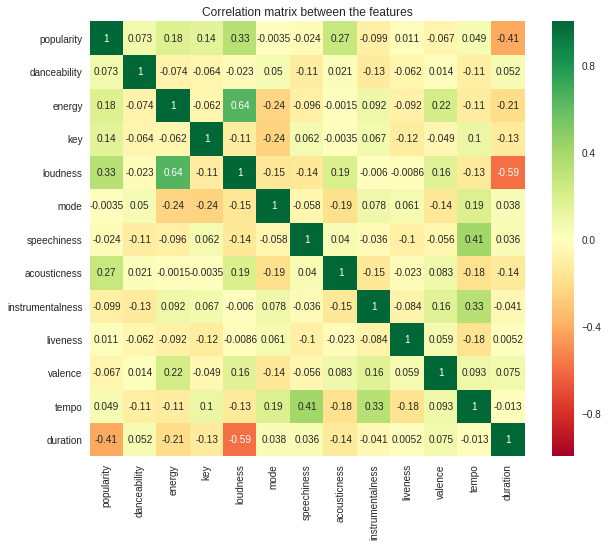

In [14]:
correlation_matrix_only_reggaeton = df_only_reggaeton_cleaned.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix_only_reggaeton, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.show()

### 1.4- Exploración rápida de variables

#### 1.4.1- Exploración variables df_all_types_cleaned

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5c627be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5a692048>]], dtype=object)

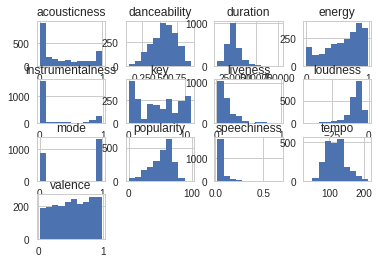

In [15]:
df_all_types_cleaned.hist()

#### 1.4.2- Exploración variables df_only_reggaeton_cleaned

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5a2f2a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b59d88710>]], dtype=object)

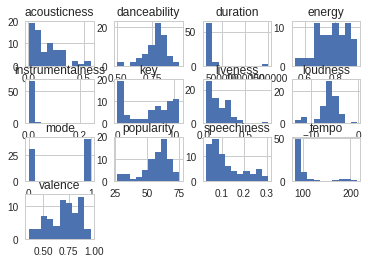

In [16]:
df_only_reggaeton_cleaned.hist()

## 02- Unir datasets y retornar un csv a output/P2-alldatasets.csv

* En este paso se unen ambos datasets los cuales están cargados en memoria a través de la estructura de dato DataFrames.

In [17]:
df_all_types_cleaned['marca_reggaeton'] = 0
df_only_reggaeton_cleaned['marca_reggaeton'] = 1

df_all_set_clean = pd.concat([df_all_types_cleaned,df_only_reggaeton_cleaned],ignore_index=True)
df_all_set_clean.to_csv('output/P2-all_datasets.csv', sep=',')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 03- Entrenamiento de modelos

#### 3.1- Selección del dataset para entrenamiento

In [18]:
df_train = df_all_set_clean

### 3.1- Selección de modelos

* Para seleccionar los modelos a entrenar primero utilizo una estrategia de procesamiento bash, el cual me va a permitir saber de antemano cuales modelos son los que mejor rinden.
* Para esto se guarda en un diccionario todos los modelos ya declarados para luego realizar todo el procesamiento asociado.

In [19]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators = 18),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB()
}

In [20]:
def get_train_test(df, y_col, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    del df_train[y_col]
    del df_test[y_col]
 
    X_train = df_train.values
    X_test = df_test.values
    return X_train, Y_train, X_test, Y_test
 
y_col = 'marca_reggaeton'
train_test_ratio = 0.7
X_train, Y_train, X_test, Y_test = get_train_test(df_train, y_col, train_test_ratio)

### 3.2- Entrenamiento via un proceso batch

* Se crea una función la cual es llamada para realizar el proceso batch.
* El método score() retorna el resultado del método accuracy_score() el cual está incluido en el módulo metrics de sciki-learn. 

In [21]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,4)), columns = ['classifier', 'train_score', 'test_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'test_score'] = test_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [22]:
df_results = batch_classify(X_train, Y_train, X_test, Y_test)
display(df_results.sort_values(by='test_score', ascending=False))

trained Logistic Regression in 0.01 s
trained Nearest Neighbors in 0.01 s
trained Linear SVM in 0.47 s
trained Gradient Boosting Classifier in 0.14 s
trained Decision Tree in 0.01 s
trained Random Forest in 0.03 s
trained Neural Net in 3.33 s
trained Naive Bayes in 0.01 s


,classifier,train_score,test_score,training_time
3,Gradient Boosting Classifier,1.000000,0.980243,0.143875
5,Random Forest,0.999388,0.974164,0.028967
0,Logistic Regression,0.971236,0.969605,0.005191
1,Nearest Neighbors,0.971236,0.969605,0.008452
2,Linear SVM,1.000000,0.969605,0.469732
6,Neural Net,0.969400,0.969605,3.329334
4,Decision Tree,1.000000,0.965046,0.009039
7,Naive Bayes,0.958384,0.958967,0.005702


* En base a esto, se seleccionan el top 3 de los modelos previamente nombrados, los cuales son: **Gradient Boosting Classifier (GBC), Random Forest y Logistic Regression**.

### 3.3- Crear modelo Gradient Boosting Classifier (GBT)

In [23]:
model_GBT = GradientBoostingClassifier()
model_GBT.fit(X_train, Y_train)
filename_model_GBT = 'output/P3-classification_isreggaeton_GBT.sav'
pickle.dump(model_GBT, open(filename_model_GBT, 'wb'))

In [24]:
# Cargar el modelo guardado en disco
loaded_model = pickle.load(open(filename_model_GBT, 'rb'))
# Para testing: cargar el modelo guardado
result = loaded_model.score(X_test, Y_test)
print(result)

0.978723404255


In [25]:
classification_GBT = model_GBT.predict(df_test_cleaned)
df_classifications = pd.DataFrame({'marca_reggaeton':classification_GBT}) 
df_classifications.index += 1 
df_classifications.tail()

,marca_reggaeton
46,0
47,0
48,0
49,0
50,0


In [26]:
classification_probabilities_GBT = model_GBT.predict_proba(df_test_cleaned)
data_GBT = pd.DataFrame(classification_probabilities_GBT)[1]

df_classification_probabilities_GBT = pd.DataFrame({'probabilidad_reggaeton':data_GBT}) 
df_classification_probabilities_GBT.index += 1 

df_GBT = df_classifications.join(df_classification_probabilities_GBT)
df_GBT.tail()

df_test_classificated_GBT = df_test_cleaned.join(df_GBT)
df_test_classificated_GBT.to_csv('output/P5-test_dataset_classificated_GBT.csv', sep=',')

#### 3.3.1- Evaluación del modelo GBT

In [27]:
y_pred_class = model_GBT.predict(X_test)
y_pred_prob= model_GBT.predict_proba(X_test)

print(metrics.confusion_matrix(Y_test, y_pred_class))

confusion = metrics.confusion_matrix(Y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Misclassification Rate: ", 1 - metrics.accuracy_score(Y_test, y_pred_class))
print("Specificity: ", TN / float(TN + FP))
print("False Positive Rate: ", FP / float(TN + FP))

from sklearn import metrics
target_names = ['marca_reggaeton = 0', 'marca_reggaeton = 1']
print(metrics.classification_report(Y_test, y_pred_class, target_names=target_names))
print ("Accuracy: ", metrics.accuracy_score(Y_test, y_pred_class))
print ("ROC: ", metrics.roc_auc_score(Y_test, y_pred_class))

[[633   5]
 [  9  11]]
Misclassification Rate:  0.0212765957447
Specificity:  0.992163009404
False Positive Rate:  0.00783699059561
                     precision    recall  f1-score   support

marca_reggaeton = 0       0.99      0.99      0.99       638
marca_reggaeton = 1       0.69      0.55      0.61        20

        avg / total       0.98      0.98      0.98       658

Accuracy:  0.978723404255
ROC:  0.771081504702


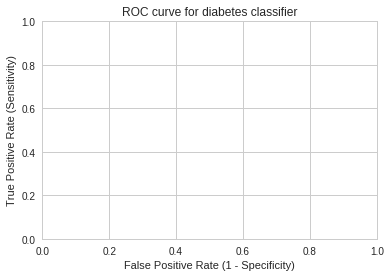

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

### 3.4-  Crear modelo Random Forest

In [29]:
model_RANDOMFOREST = RandomForestClassifier(n_estimators = 18)
model_RANDOMFOREST.fit(X_train, Y_train)
filename_model_RANDOMFOREST = 'output/P3-classification_isreggaeton_RANDOMFOREST.sav'
pickle.dump(model_RANDOMFOREST, open(filename_model_RANDOMFOREST, 'wb'))
# Testing: cargar el modelo guardado en disco
loaded_model = pickle.load(open(filename_model_RANDOMFOREST, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.978723404255


In [30]:
classification_RANDOMFOREST = model_RANDOMFOREST.predict(df_test_cleaned)
df_classifications = pd.DataFrame({'marca_reggaeton':classification_RANDOMFOREST}) 
df_classifications.index += 1 
df_classifications.head()
df_classifications.tail()

,marca_reggaeton
46,0
47,0
48,0
49,0
50,0


In [31]:
classification_probabilities_RANDOMFOREST = model_RANDOMFOREST.predict_proba(df_test_cleaned)
data_RANDOMFOREST = pd.DataFrame(classification_probabilities_RANDOMFOREST)[1]
df_classification_probabilities_RANDOMFOREST = pd.DataFrame({'probabilidad_reggaeton':data_RANDOMFOREST}) 
df_classification_probabilities_RANDOMFOREST.index += 1 
df_RANDOMFOREST = df_classifications.join(df_classification_probabilities_RANDOMFOREST)
df_RANDOMFOREST.tail()

df_test_classificated_RANDOMFOREST = df_test_cleaned.join(df_RANDOMFOREST)
df_test_classificated_RANDOMFOREST.to_csv('output/P5-test_dataset_classificated_RANDOMFOREST.csv', sep=',')

#### 3.4.1- Evaluación del modelo Random Forest

In [32]:
y_pred_class = model_RANDOMFOREST.predict(X_test)
y_pred_prob= model_RANDOMFOREST.predict_proba(X_test)

print(metrics.confusion_matrix(Y_test, y_pred_class))

confusion = metrics.confusion_matrix(Y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Misclassification Rate: ", 1 - metrics.accuracy_score(Y_test, y_pred_class))
print("Specificity: ", TN / float(TN + FP))
print("False Positive Rate: ", FP / float(TN + FP))

from sklearn import metrics
target_names = ['marca_reggaeton = 0', 'marca_reggaeton = 1']
print(metrics.classification_report(Y_test, y_pred_class, target_names=target_names))
print ("Accuracy: ", metrics.accuracy_score(Y_test, y_pred_class))
print ("ROC: ", metrics.roc_auc_score(Y_test, y_pred_class))

[[638   0]
 [ 14   6]]
Misclassification Rate:  0.0212765957447
Specificity:  1.0
False Positive Rate:  0.0
                     precision    recall  f1-score   support

marca_reggaeton = 0       0.98      1.00      0.99       638
marca_reggaeton = 1       1.00      0.30      0.46        20

        avg / total       0.98      0.98      0.97       658

Accuracy:  0.978723404255
ROC:  0.65


### 3.5-  Crear modelo por regresión logistica

In [33]:
model_LR = LogisticRegression()
model_LR.fit(X_train, Y_train)

y_pred_class = model_LR.predict(X_test)

filename_model_LR = 'output/P3-classification_isreggaeton_LR.sav'
pickle.dump(model_LR, open(filename_model_LR, 'wb'))

In [34]:
# Cargar el modelo almacenado en disco
loaded_model = pickle.load(open(filename_model_LR, 'rb'))
# Testing: verificar el modelo con el conjunto de prueba
result = loaded_model.score(X_test, Y_test)
print(result)

0.969604863222


In [35]:
classification_LR = model_LR.predict(df_test_cleaned)
df_classifications = pd.DataFrame({'marca_reggaeton':classification_LR}) 
df_classifications.index += 1 
df_classifications.head()
df_classifications.tail()

,marca_reggaeton
46,0
47,0
48,0
49,0
50,0


In [36]:
classification_probabilities_LR = model_LR.predict_proba(df_test_cleaned)
data_LR = pd.DataFrame(classification_probabilities_LR)[1]
df_classification_probabilities_LR = pd.DataFrame({'probabilidad_reggaeton':data_LR}) 
df_classification_probabilities_LR.index += 1 
df_LR = df_classifications.join(df_classification_probabilities_LR)
df_LR.tail()

,marca_reggaeton,probabilidad_reggaeton
46,0,0.014807
47,0,0.003253
48,0,0.029271
49,0,0.011356
50,0,0.029606


In [37]:
df_test_classificated_LR = df_test_cleaned.join(df_LR)
df_test_classificated_LR.to_csv('output/P5-test_dataset_classificated_LR.csv', sep=',')

#### 3.5- Evaluación del modelo LR

In [38]:
print(metrics.confusion_matrix(Y_test, y_pred_class))

confusion = metrics.confusion_matrix(Y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("Misclassification Rate: ", 1 - metrics.accuracy_score(Y_test, y_pred_class))
print("Specificity: ", TN / float(TN + FP))
print("False Positive Rate: ", FP / float(TN + FP))

y_pred_class = model_LR.predict(X_test)
y_pred_prob= model_LR.predict_proba(X_test)

from sklearn import metrics
target_names = ['marca_reggaeton = 0', 'marca_reggaeton = 1']
print(metrics.classification_report(Y_test, y_pred_class, target_names=target_names))
print ("Accuracy: ", metrics.accuracy_score(Y_test, y_pred_class))
print ("ROC: ", metrics.roc_auc_score(Y_test, y_pred_class))

[[638   0]
 [ 20   0]]
Misclassification Rate:  0.0303951367781
Specificity:  1.0
False Positive Rate:  0.0
                     precision    recall  f1-score   support

marca_reggaeton = 0       0.97      1.00      0.98       638
marca_reggaeton = 1       0.00      0.00      0.00        20

        avg / total       0.94      0.97      0.95       658

Accuracy:  0.969604863222
ROC:  0.5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Glosario

* True Positives (TP): we correctly predicted that they do have diabetes
* True Negatives (TN): we correctly predicted that they don't have diabetes
* False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")
* False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")

* Classification Accuracy: Overall, how often is the classifier correct?
* Accuracy: para indicar cuan a menudo el clasificador esta correcto
* Classification Error: Overall, how often is the classifier incorrect? 
* Also known as "Misclassification Rate"
* Error en la clasificación: cada cuanto el clasificador esta incorrecto
* Sensitivity: When the actual value is positive, how often is the prediction correct?
* Sensitivity = True Posotive Rate = Recall = cuan a menudo la predicción es correcta
* How "sensitive" is the classifier to detecting positive instances?
* Also known as "True Positive Rate" or "Recall"
* Specificity: When the actual value is negative, how often is the prediction correct?
* How "specific" (or "selective") is the classifier in predicting positive instances?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?